<h1 style="text-align: center;"><strong>Prediction of Viral Load Suppression Project</strong></h1>

<p style="text-align: center;"><strong>Dègninou Yehadji</strong><br /><span style="color: #0000ff;">TU Dublin, Blanchardstown Campus</span><br /><span style="color: #0000ff;">Dublin 15</span><br /><span style="color: #0000ff;"><em>Email: <a href="mailto:degninou.yehadji@fulbrightmail.org">degninou.yehadji@fulbrightmail.org</a></em></span> </p>

This is a project conducted using an HIV treatement dataset to predict viral load supression for individuals in the cohort. 

The target variable is Last ART VL Count recoded into a binary variable indicating whether the individual has viral load suppressed or not. The threshold of < 1000 RNA copies/ml is used to define suppressed viral load. 

This Python script is develloped to meet the objective presented above. Specifically, it is intended to: 
- Perform data management tasks on the original dataset 
- Show visualisations of the data using the Python plotting tools
- Develop and evaluate 3 classification models to predict viral load supression 
- Perform cross validation (use k-fold cross validation)
- Perform some searching for optimal values of the hyper or tuning parameters (see GridSearchCV and/or RandomizedSearchCV) in scikit-learn.
- Show the performance of the models by generating classification reports/confusion matrices, ROC curves etc.
- Comment on the process as a whole and in particular on the result of the estimation.

## Import required packages 

In [1]:
# Import required packages 

import os

from sklearnex import patch_sklearn
patch_sklearn()
from sklearnex.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

from mlxtend.classifier import StackingClassifier
from sklearn import metrics 
from sklearn.metrics import RocCurveDisplay

import pickle
import joblib

import scikitplot as skplt
import missingno as msno 
import math
import statsmodels.api as sm
from scipy.stats import sem
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import xlrd
import time

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Set working directory and load dataset

In [2]:
# Set working directory
os.chdir ("..\..\MCS Thesis\Modeling")

# Read final data
data_train01 = pd.read_excel('data_train_clean.xlsx')
data_test01 = pd.read_excel('data_test_clean.xlsx')

# Copy final data
data_train02 = data_train01.copy()
data_test02 = data_test01.copy()

In [3]:
# Take a random 30% subset of the data
data_train02_subset = data_train02.sample(frac=0.1, random_state=40)
data_test02_subset = data_test02.sample(frac=0.1, random_state=40)

In [4]:
data_train02.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16793 entries, 0 to 16792
Data columns (total 45 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   Gender_Male                                16793 non-null  int64
 1   Regiment schedule_3-Month                  16793 non-null  int64
 2   Regiment schedule_6-Month                  16793 non-null  int64
 3   Regiment schedule_Regular                  16793 non-null  int64
 4   Prior ART_Naive                            16793 non-null  int64
 5   Method into ART_New                        16793 non-null  int64
 6   TB Rx Started_Yes                          16793 non-null  int64
 7   TPT Outcome_No treatement                  16793 non-null  int64
 8   TPT Outcome_Other                          16793 non-null  int64
 9   TPT Outcome_Rx completed                   16793 non-null  int64
 10  Regimen At Baseline_1S3E                   167

In [5]:
data_test02.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4054 entries, 0 to 4053
Data columns (total 45 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   Gender_Male                                4054 non-null   int64
 1   Regiment schedule_3-Month                  4054 non-null   int64
 2   Regiment schedule_6-Month                  4054 non-null   int64
 3   Regiment schedule_Regular                  4054 non-null   int64
 4   Prior ART_Naive                            4054 non-null   int64
 5   Method into ART_New                        4054 non-null   int64
 6   TB Rx Started_Yes                          4054 non-null   int64
 7   TPT Outcome_No treatement                  4054 non-null   int64
 8   TPT Outcome_Other                          4054 non-null   int64
 9   TPT Outcome_Rx completed                   4054 non-null   int64
 10  Regimen At Baseline_1S3E                   4054 

In [6]:
data_train02_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1679 entries, 14010 to 7780
Data columns (total 45 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   Gender_Male                                1679 non-null   int64
 1   Regiment schedule_3-Month                  1679 non-null   int64
 2   Regiment schedule_6-Month                  1679 non-null   int64
 3   Regiment schedule_Regular                  1679 non-null   int64
 4   Prior ART_Naive                            1679 non-null   int64
 5   Method into ART_New                        1679 non-null   int64
 6   TB Rx Started_Yes                          1679 non-null   int64
 7   TPT Outcome_No treatement                  1679 non-null   int64
 8   TPT Outcome_Other                          1679 non-null   int64
 9   TPT Outcome_Rx completed                   1679 non-null   int64
 10  Regimen At Baseline_1S3E                   1

### Create predictors and targets - Training and Test

In [7]:
# Create a subset with predictors - Training set
xtrain = data_train02.drop(columns=['VL Suppressed_Yes'])
xtrain_subset = data_train02_subset.drop(columns=['VL Suppressed_Yes'])

# Create a subset with predictors - Test set 
xtest = data_test02.drop(columns=['VL Suppressed_Yes'])
xtest_subset = data_test02_subset.drop(columns=['VL Suppressed_Yes'])

# Target -- Training set
ytrain = data_train02[['VL Suppressed_Yes']]
ytrain_subset = data_train02_subset[['VL Suppressed_Yes']]

# Target -- Test set
ytest = data_test02[['VL Suppressed_Yes']]
ytest_subset = data_test02_subset[['VL Suppressed_Yes']]

# Take 30% random subset of the training set
# xtrain_subset, _, ytrain_subset, _ = train_test_split(xtrain, ytrain, 
# test_size=0.7, stratify=ytrain, random_state=40)

##  Non-linear Support vector machine (SVM)

#### Rbf SVM Parameter tuning - C and Gama

In [8]:
# Create the non-linear SVM model with radial basis function (RBF) kernel
rbfSVC = SVC(kernel='rbf', random_state=40) # Random seed for reproducibility 

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],  # Regularization parameter
    'gamma': [0.5, 0.6, 0.7, 0.8, 0.9] # Kernel coefficient
}

# Perform nested cross-validation with parameter tuning
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=40)
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=40)

start_time = time.time()

grid_search = GridSearchCV(estimator=rbfSVC, param_grid=param_grid, cv=inner_cv, n_jobs=-1)
grid_search.fit(xtrain, ytrain.values.ravel())

# Print the best parameters found
print("Best parameters: ", grid_search.best_params_)

# Get the best estimator
best_model = grid_search.best_estimator_

# Perform cross-validation with the best estimator
scores = cross_val_score(best_model, xtrain_subset, ytrain_subset.values.ravel(), cv=outer_cv)

end_time = time.time()

# Calculate mean accuracy
mean_accuracy = np.mean(scores)
# Calculate standard deviation
std_dev = np.std(scores)
# Calculate 95% confidence interval
confidence = 0.95
standard_error = sem(scores)
margin_error = standard_error * 1.96
confidence_interval = mean_accuracy - margin_error, mean_accuracy + margin_error

# Print the cross-validation scores
print("Cross-validation scores: ", scores)
print("Mean accuracy: {:.4f}".format(mean_accuracy))
print("Standard deviation: {:.4f}".format(std_dev))
print("95% Confidence Interval: {:.4f} - {:.4f}".format(*confidence_interval))

# Print the execution time
execution_time = end_time - start_time
print("Execution time: {:.2f} seconds".format(execution_time))

Best parameters:  {'C': 10, 'gamma': 0.9}
Cross-validation scores:  [0.75       0.75       0.77380952 0.71428571 0.75       0.79761905
 0.73809524 0.72619048 0.73214286 0.79041916]
Mean accuracy: 0.7523
Standard deviation: 0.0259
95% Confidence Interval: 0.7353 - 0.7692
Execution time: 1465.08 seconds


#### Evaluate the model with optimal parameters on test set

In [9]:
# Create SVM classifer object with the optimal parameters
SVM_clf = SVC(kernel='rbf', C = 10, gamma = 0.9, random_state = 40)

# Train the best SVM Classifer
SVM_clf = SVM_clf.fit(xtrain, ytrain.values.ravel())

# Save the model
joblib.dump(SVM_clf, 'models\SVM_clf.pkl')

#Predict the response for test dataset
target_expected = ytest
target_predicted = SVM_clf.predict(xtest)

# summarize the fit of the model
print('Classification report:\n', metrics.classification_report(target_expected, 
                                                                target_predicted))
print('F1 Score: ', metrics.f1_score(target_expected, target_predicted))
print('Accuracy Score: ', metrics.accuracy_score(target_expected, target_predicted))
print('Confusion matrix:\n', metrics.confusion_matrix(target_expected, target_predicted))

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       457
           1       0.89      1.00      0.94      3597

    accuracy                           0.89      4054
   macro avg       0.94      0.50      0.47      4054
weighted avg       0.90      0.89      0.83      4054

F1 Score:  0.9403921568627451
Accuracy Score:  0.88751850024667
Confusion matrix:
 [[   1  456]
 [   0 3597]]


## Random Forest

### Parameter tuning

In [10]:
# Create the Random Forest classifier
rf = RandomForestClassifier(random_state = 40)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [500, 1000, 1500, 2000],  # Number of trees in the forest
    # 'criterion': ['gini', 'entropy'],  # Splitting criterion 
    'max_depth': [None, 10, 30, 50, 70, 90, 100],  # Maximum depth of each tree
    # 'min_samples_split': [2, 4, 6],  # Minimum number of samples required to split an internal node
    # 'min_samples_leaf': [1, 3, 5, 7]  # Minimum number of samples required at each leaf node
    # 'max_features': [None, 'sqrt', 'log2'],  # Number of features to consider at each split
    # 'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
}

# Perform nested cross-validation with parameter tuning
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=40)
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=40)

start_time = time.time()

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=inner_cv, n_jobs = -1)
grid_search.fit(xtrain, ytrain.values.ravel())

end_time = time.time()

# Print the best parameters found
print("Best parameters: ", grid_search.best_params_)

# Get the best estimator
best_model = grid_search.best_estimator_

# Perform cross-validation with the best estimator
scores = cross_val_score(best_model, xtrain_subset, ytrain_subset.values.ravel(), cv=outer_cv)

# Calculate mean accuracy
mean_accuracy = np.mean(scores)
# Calculate standard deviation
std_dev = np.std(scores)
# Calculate 95% confidence interval
confidence = 0.95
standard_error = sem(scores)
margin_error = standard_error * 1.96
confidence_interval = mean_accuracy - margin_error, mean_accuracy + margin_error

# Print the cross-validation scores
print("Cross-validation scores: ", scores)
print("Mean accuracy: {:.4f}".format(mean_accuracy))
print("Standard deviation: {:.4f}".format(std_dev))
print("95% Confidence Interval: {:.4f} - {:.4f}".format(*confidence_interval))

# Print the execution time
execution_time = end_time - start_time
print("Execution time: {:.2f} seconds".format(execution_time))

Best parameters:  {'max_depth': None, 'n_estimators': 1000}
Cross-validation scores:  [0.85714286 0.80952381 0.83928571 0.82142857 0.77380952 0.83928571
 0.76785714 0.79761905 0.82142857 0.83233533]
Mean accuracy: 0.8160
Standard deviation: 0.0275
95% Confidence Interval: 0.7980 - 0.8340
Execution time: 1094.73 seconds


### Evaluate the model with optimal parameters on test set

In [11]:
# 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000
# Create RF classifer object with the optimal parameters
RFR_clf = RandomForestClassifier(max_depth = None, n_estimators = 1000, random_state = 40)

# Train the best RF Classifer
RFR_clf = RFR_clf.fit(xtrain, ytrain.values.ravel())

# Save the model
joblib.dump(RFR_clf, 'RDF_clf.pkl')

#Predict the response for test dataset
target_expected = ytest
target_predicted = RFR_clf.predict(xtest)

# summarize the fit of the model
print('Classification report:\n', metrics.classification_report(target_expected, 
                                                                target_predicted))
print('F1 Score: ', metrics.f1_score(target_expected, target_predicted))
print('Accuracy Score: ', metrics.accuracy_score(target_expected, target_predicted))
print('Confusion matrix:\n', metrics.confusion_matrix(target_expected, target_predicted))

Classification report:
               precision    recall  f1-score   support

           0       0.52      0.30      0.38       457
           1       0.92      0.97      0.94      3597

    accuracy                           0.89      4054
   macro avg       0.72      0.63      0.66      4054
weighted avg       0.87      0.89      0.88      4054

F1 Score:  0.9396645021645021
Accuracy Score:  0.889985199802664
Confusion matrix:
 [[ 135  322]
 [ 124 3473]]


In [12]:
feature_names = [col for col in data_train02.columns if col != 'VL Suppressed_Yes']

### Determining feature importing based on RF

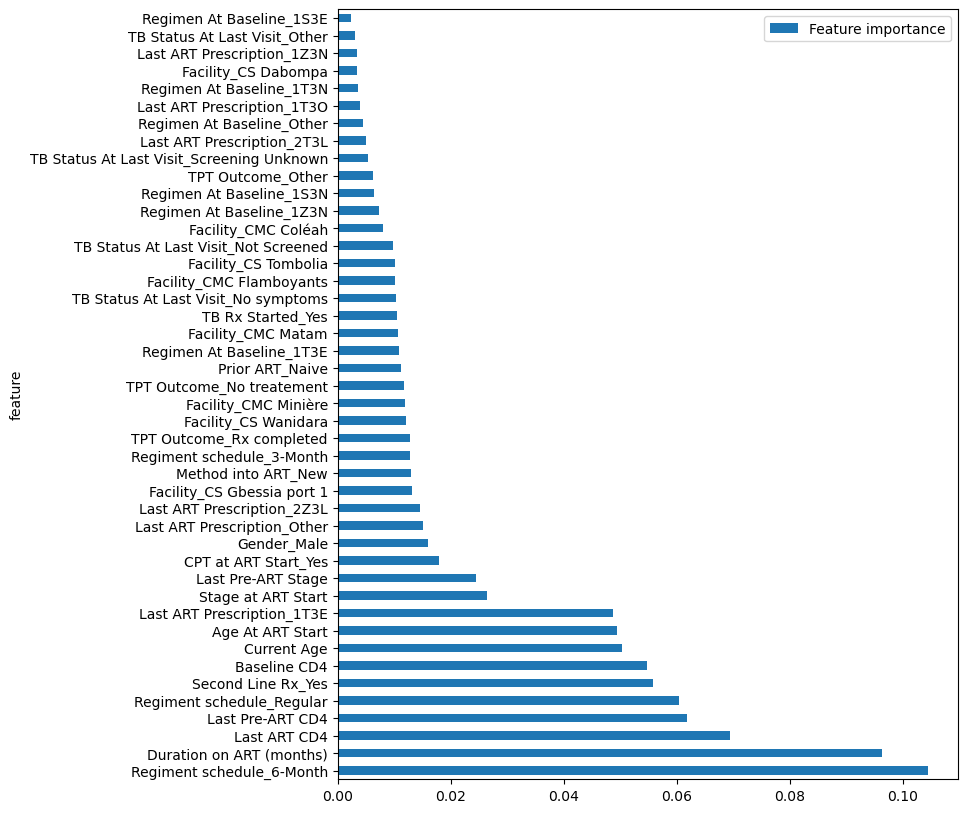

In [13]:
rf_feature_imp = RFR_clf.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

rf_feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
for item in rf_feature_imp: rf_feature_importance["Feature importance"] = rf_feature_imp
rf_feature_importance = rf_feature_importance.sort_values(by = ["Feature importance"], ascending=False)

rf_feature_importance.to_excel('rf_feature_importance.xlsx', encoding='utf-8-sig', header = True)

ax = rf_feature_importance.plot.barh(x='feature', y='Feature importance', figsize=(8, 10))
plt.show()

## Gaussian Naive Bayes

### Naive Bayes cross validation

In [14]:
# Create the Gaussian Naive Bayes classifier
nb = GaussianNB() # NB does not need random_state 

# Perform nested cross-validation
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=40)
# inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=40)

start_time = time.time()

# Train the model
nb.fit(xtrain, ytrain.values.ravel())

# Perform cross-validation with the Gaussian Naive Bayes
scores = cross_val_score(nb, xtrain_subset, ytrain_subset.values.ravel(), cv=outer_cv)

end_time = time.time()

# Calculate mean accuracy
mean_accuracy = np.mean(scores)
# Calculate standard deviation
std_dev = np.std(scores)
# Calculate 95% confidence interval
confidence = 0.95
standard_error = sem(scores)
margin_error = standard_error * 1.96
confidence_interval = mean_accuracy - margin_error, mean_accuracy + margin_error

# Print the cross-validation scores
print("Cross-validation scores: ", scores)
print("Mean accuracy: {:.4f}".format(mean_accuracy))
print("Standard deviation: {:.4f}".format(std_dev))
print("95% Confidence Interval: {:.4f} - {:.4f}".format(*confidence_interval))

# Print the execution time
execution_time = end_time - start_time
print("Execution time: {:.2f} seconds".format(execution_time))

Cross-validation scores:  [0.76785714 0.70833333 0.73214286 0.6547619  0.77380952 0.66666667
 0.6547619  0.70833333 0.80357143 0.76646707]
Mean accuracy: 0.7237
Standard deviation: 0.0510
95% Confidence Interval: 0.6904 - 0.7570
Execution time: 0.08 seconds


### Performance of the model on the test set

In [16]:
# Create Gaussian Naive Bayes (NB) classifer object
NB_clf = GaussianNB()

# Train NB Classifer
NB_clf = NB_clf.fit(xtrain, ytrain.values.ravel())

# Save the model
joblib.dump(NB_clf, 'NB_clf.pkl')

#Predict the response for test dataset
target_expected = ytest
target_predicted = NB_clf.predict(xtest)

# summarize the fit of the model
print('Classification report:\n', metrics.classification_report(target_expected, 
                                                                target_predicted))
print('F1 Score: ', metrics.f1_score(target_expected, target_predicted))
print('Accuracy Score: ', metrics.accuracy_score(target_expected, target_predicted))
print('Confusion matrix:\n', metrics.confusion_matrix(target_expected, target_predicted))

Classification report:
               precision    recall  f1-score   support

           0       0.33      0.56      0.41       457
           1       0.94      0.85      0.89      3597

    accuracy                           0.82      4054
   macro avg       0.63      0.71      0.65      4054
weighted avg       0.87      0.82      0.84      4054

F1 Score:  0.8931642617694214
Accuracy Score:  0.819190922545634
Confusion matrix:
 [[ 257  200]
 [ 533 3064]]


### Logistic regression model implementation and evaluation

In [17]:
# Create the Logistic Regression classifier
lr = LogisticRegression(random_state = 40, solver = 'newton-cholesky')
# lr = LogisticRegression(random_state = 40)

# Define the parameter grid for GridSearchCV
# param_grid = {
    # 'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Type of regularization to be applied
    # 'C': np.logspace(-4, 4, 20),  # Inverse of regularization strength
    # 'solver': ['lbfgs', 'newton-cholesky'],  # Algorithm for optimization problem
    # 'max_iter': [i for i in range(100, 2000, 100)]
    # 'l1_ratio': np.linspace(0, 1, 10),  # The Elastic-Net mixing parameter, 
    # with 0 <= l1_ratio <= 1. l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1}
    
param_grid = {'max_iter': [i for i in range(100, 1000, 100)]}

# Perform nested cross-validation with parameter tuning
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=40)
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=40)

start_time = time.time()

grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=inner_cv, n_jobs = -1)
grid_search.fit(xtrain, ytrain.values.ravel())

# Get the best estimator
best_model = grid_search.best_estimator_

# Perform cross-validation with the best estimator
scores = cross_val_score(best_model, xtrain_subset, ytrain_subset.values.ravel(), cv=outer_cv)

end_time = time.time()

# Calculate mean accuracy
mean_accuracy = np.mean(scores)
# Calculate standard deviation
std_dev = np.std(scores)
# Calculate 95% confidence interval
confidence = 0.95
standard_error = sem(scores)
margin_error = standard_error * 1.96
confidence_interval = mean_accuracy - margin_error, mean_accuracy + margin_error

# Print the best parameters found
print("Best parameters: ", grid_search.best_params_)

# Print the cross-validation scores
print("Cross-validation scores: ", scores)
print("Mean accuracy: {:.4f}".format(mean_accuracy))
print("Standard deviation: {:.4f}".format(std_dev))
print("95% Confidence Interval: {:.4f} - {:.4f}".format(*confidence_interval))

# Print the execution time
execution_time = end_time - start_time
print("Execution time: {:.2f} seconds".format(execution_time))

Best parameters:  {'max_iter': 100}
Cross-validation scores:  [0.76785714 0.76785714 0.78571429 0.7202381  0.73214286 0.76190476
 0.7202381  0.72619048 0.76190476 0.79640719]
Mean accuracy: 0.7540
Standard deviation: 0.0262
95% Confidence Interval: 0.7370 - 0.7711
Execution time: 6.54 seconds


In [19]:
# Create Logistic regression classifer object
LOG_clf = LogisticRegression(random_state = 40, max_iter = 100, solver = 'newton-cholesky')

# Train Logistic regresion Classifer
LOG_clf = LOG_clf.fit(xtrain, ytrain.values.ravel())

# Save the model
joblib.dump(LOG_clf, 'LGR_clf.pkl')

#Predict the response for test dataset
target_expected = ytest
target_predicted = LOG_clf.predict(xtest)

# summarize the fit of the model
print('Classification report:\n', metrics.classification_report(target_expected, 
                                                                target_predicted))
print('F1 Score: ', metrics.f1_score(target_expected, target_predicted))
print('Accuracy Score: ', metrics.accuracy_score(target_expected, target_predicted))
print('Confusion matrix:\n', metrics.confusion_matrix(target_expected, target_predicted))

Classification report:
               precision    recall  f1-score   support

           0       0.29      0.75      0.42       457
           1       0.96      0.76      0.85      3597

    accuracy                           0.76      4054
   macro avg       0.62      0.76      0.63      4054
weighted avg       0.88      0.76      0.80      4054

F1 Score:  0.8507739938080496
Accuracy Score:  0.7622101628021707
Confusion matrix:
 [[ 342  115]
 [ 849 2748]]


In [20]:
# logit_model=sm.Logit(ytrain,xtrain)
# result=logit_model.fit()
# print(result.summary2())

# Add a constant to the training data for the statsmodels model
xtrain_constant = sm.add_constant(xtrain)

# Fit a model with statsmodels
logit_model = sm.Logit(ytrain, xtrain_constant)
result = logit_model.fit(maxiter=100, method='newton')

# Print the summary
print(result.summary())

         Current function value: 0.484562
         Iterations: 100
                           Logit Regression Results                           
Dep. Variable:      VL Suppressed_Yes   No. Observations:                16793
Model:                          Logit   Df Residuals:                    16754
Method:                           MLE   Df Model:                           38
Date:                Sat, 15 Jul 2023   Pseudo R-squ.:                  0.3009
Time:                        19:17:40   Log-Likelihood:                -8137.2
converged:                      False   LL-Null:                       -11640.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                        -0.6935   1.41e+06  -4.93e-07      1

C:\Users\Degninou\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Logistic regression model summary

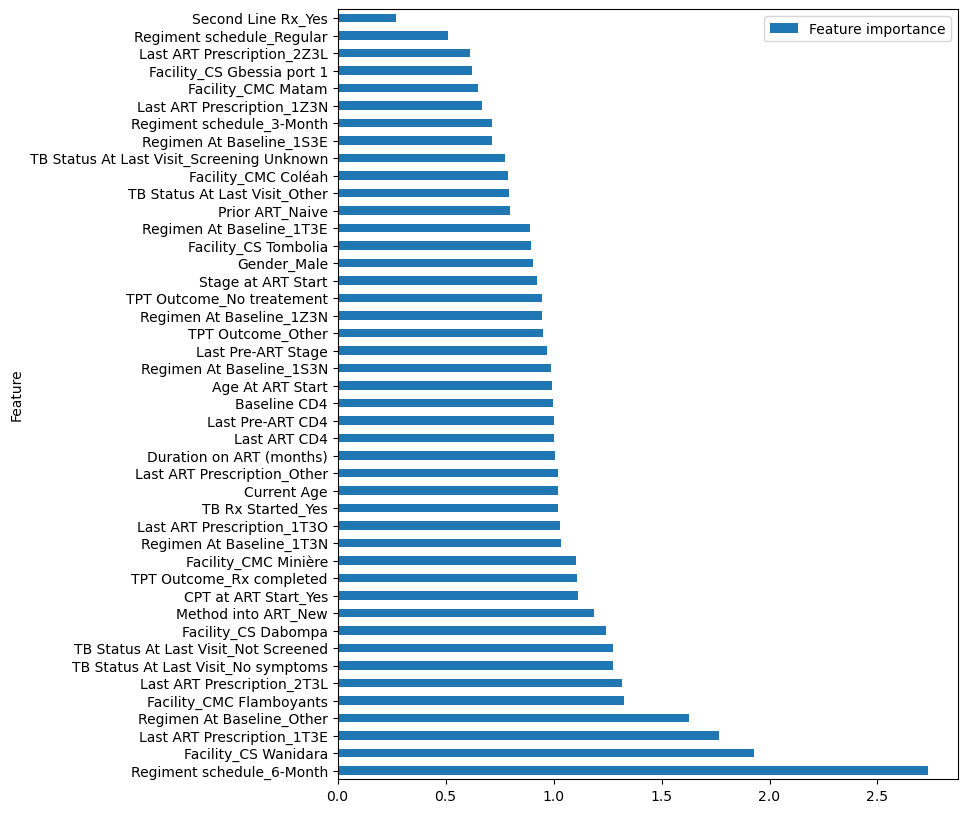

In [21]:
# Logistic regression coeficients 
logreg_coef = LOG_clf.coef_

logreg_feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
for item in logreg_coef: logreg_feature_importance["Feature importance"] = pow(math.e, item)
# for item in logreg_coef: logreg_feature_importance["Feature importance"] = item
logreg_feature_importance = logreg_feature_importance.sort_values(by = ["Feature importance"], ascending=False)

logreg_feature_importance.to_excel('logreg_feature_importance.xlsx', encoding='utf-8-sig', header = True)
 
# from sklearn.linear_model import LogisticRegression
ax = logreg_feature_importance.plot.barh(x='feature', y='Feature importance', figsize=(8, 10))
plt.ylabel('Feature')
plt.show()

### ROC Curves

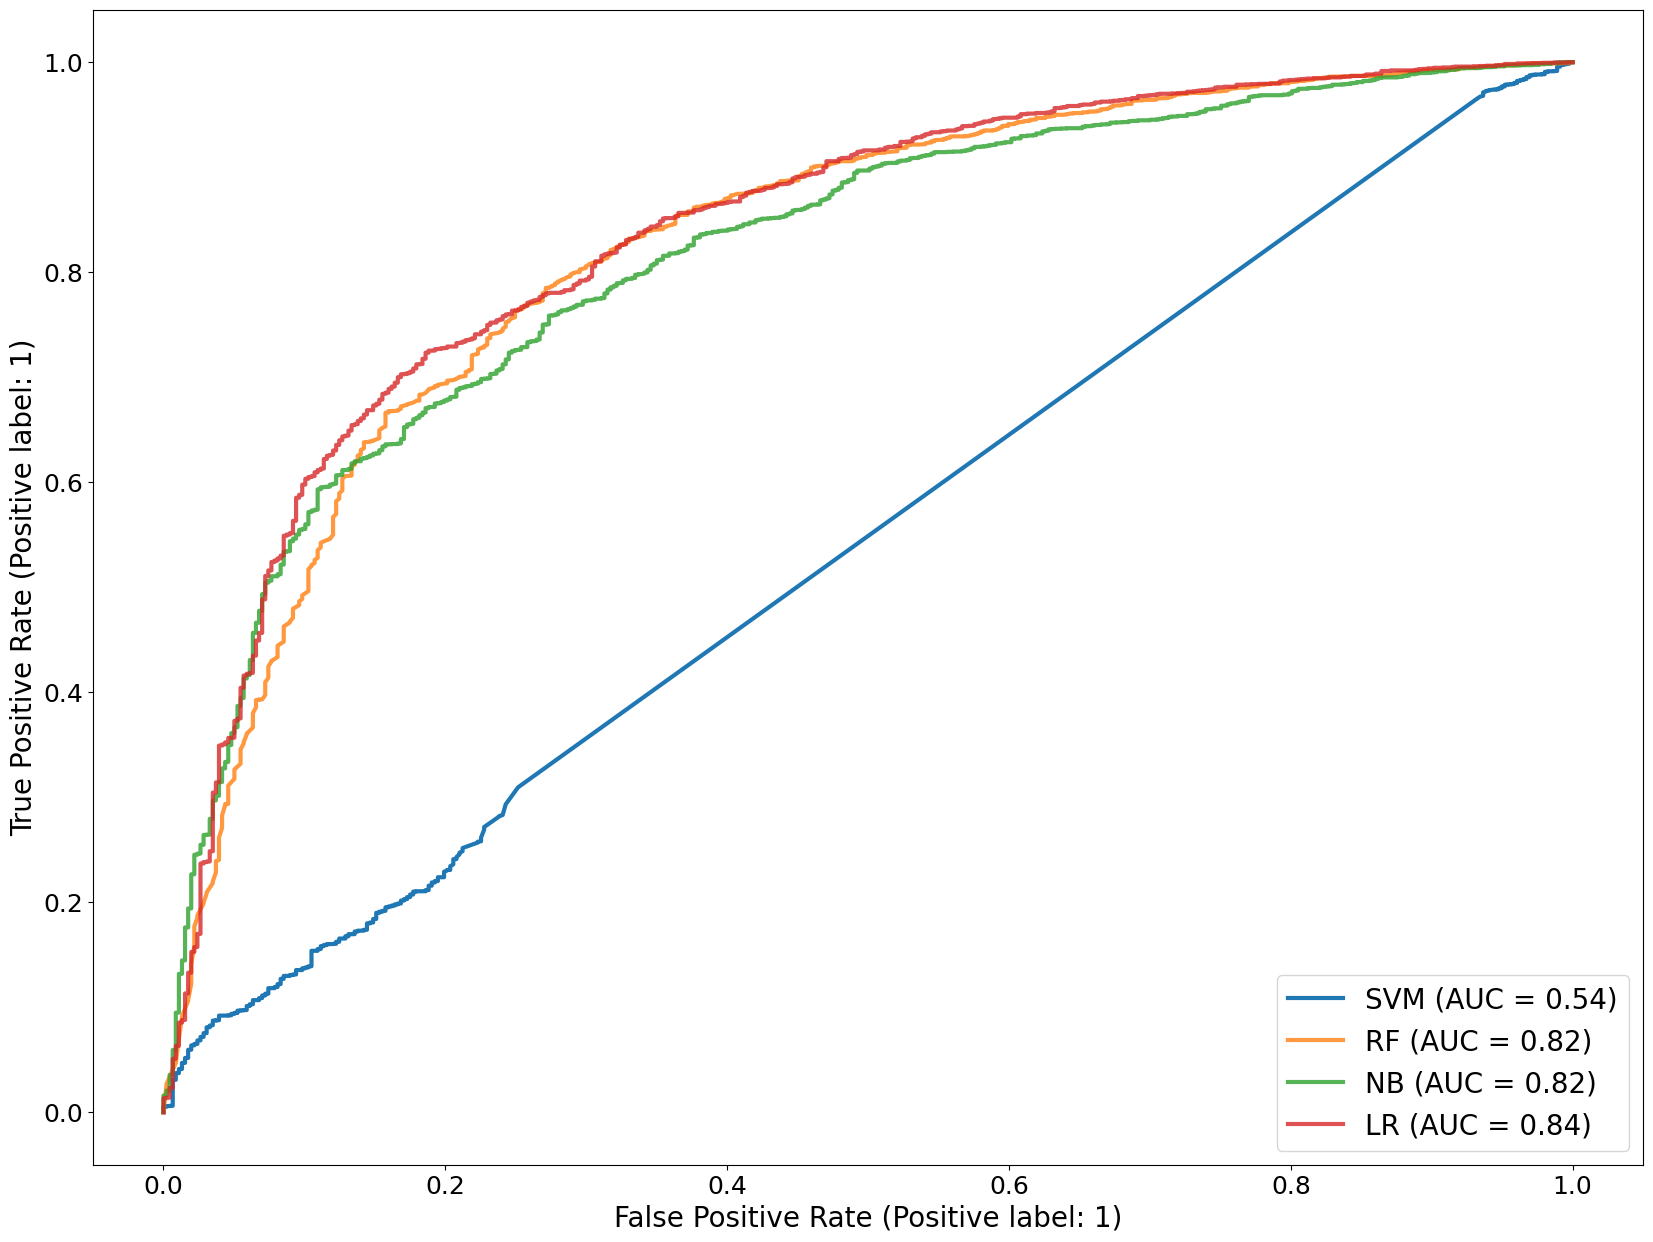

In [23]:
# SVM
SVM_clf = SVC(kernel='rbf', C = 10, gamma = 0.90, random_state = 40, probability=True)
SVM_clf.fit(xtrain, ytrain.values.ravel())
ypred1 = SVM_clf.predict_proba(xtest)[:, 1]
svc_disp = RocCurveDisplay.from_predictions(ytest, ypred1, name="SVM")

# RandomForestClassifier
RFR_clf = RandomForestClassifier(max_depth = None, n_estimators = 1000, random_state = 40)
RFR_clf = RFR_clf.fit(xtrain, ytrain.values.ravel())
ypred2 = RFR_clf.predict_proba(xtest)

ax = plt.gca()
rfc_disp = RocCurveDisplay.from_predictions(ytest, ypred2[:,1], ax=ax, name="RF", alpha=0.8)

# Naive Bayes 
NB_clf = GaussianNB()
NB_clf = NB_clf.fit(xtrain, ytrain.values.ravel())
ypred3 = NB_clf.predict_proba(xtest)

ax = plt.gca()
nyb_disp = RocCurveDisplay.from_predictions(ytest, ypred3[:,1], ax=ax, name="NB", alpha=0.8)

# Logistic regression classifer object
LOG_clf= LogisticRegression(random_state = 40, max_iter = 100, solver = 'newton-cholesky')
LOG_clf = LOG_clf.fit(xtrain, ytrain.values.ravel())
ypred4 = LOG_clf.predict_proba(xtest)

plt.rcParams['figure.figsize'] = [20, 15]
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 20

ax = plt.gca()
lrg_disp = RocCurveDisplay.from_predictions(ytest, ypred4[:, 1], ax=ax, name="LR", alpha=0.8)

### Stacking classifiers

['STK_clf4.pkl']

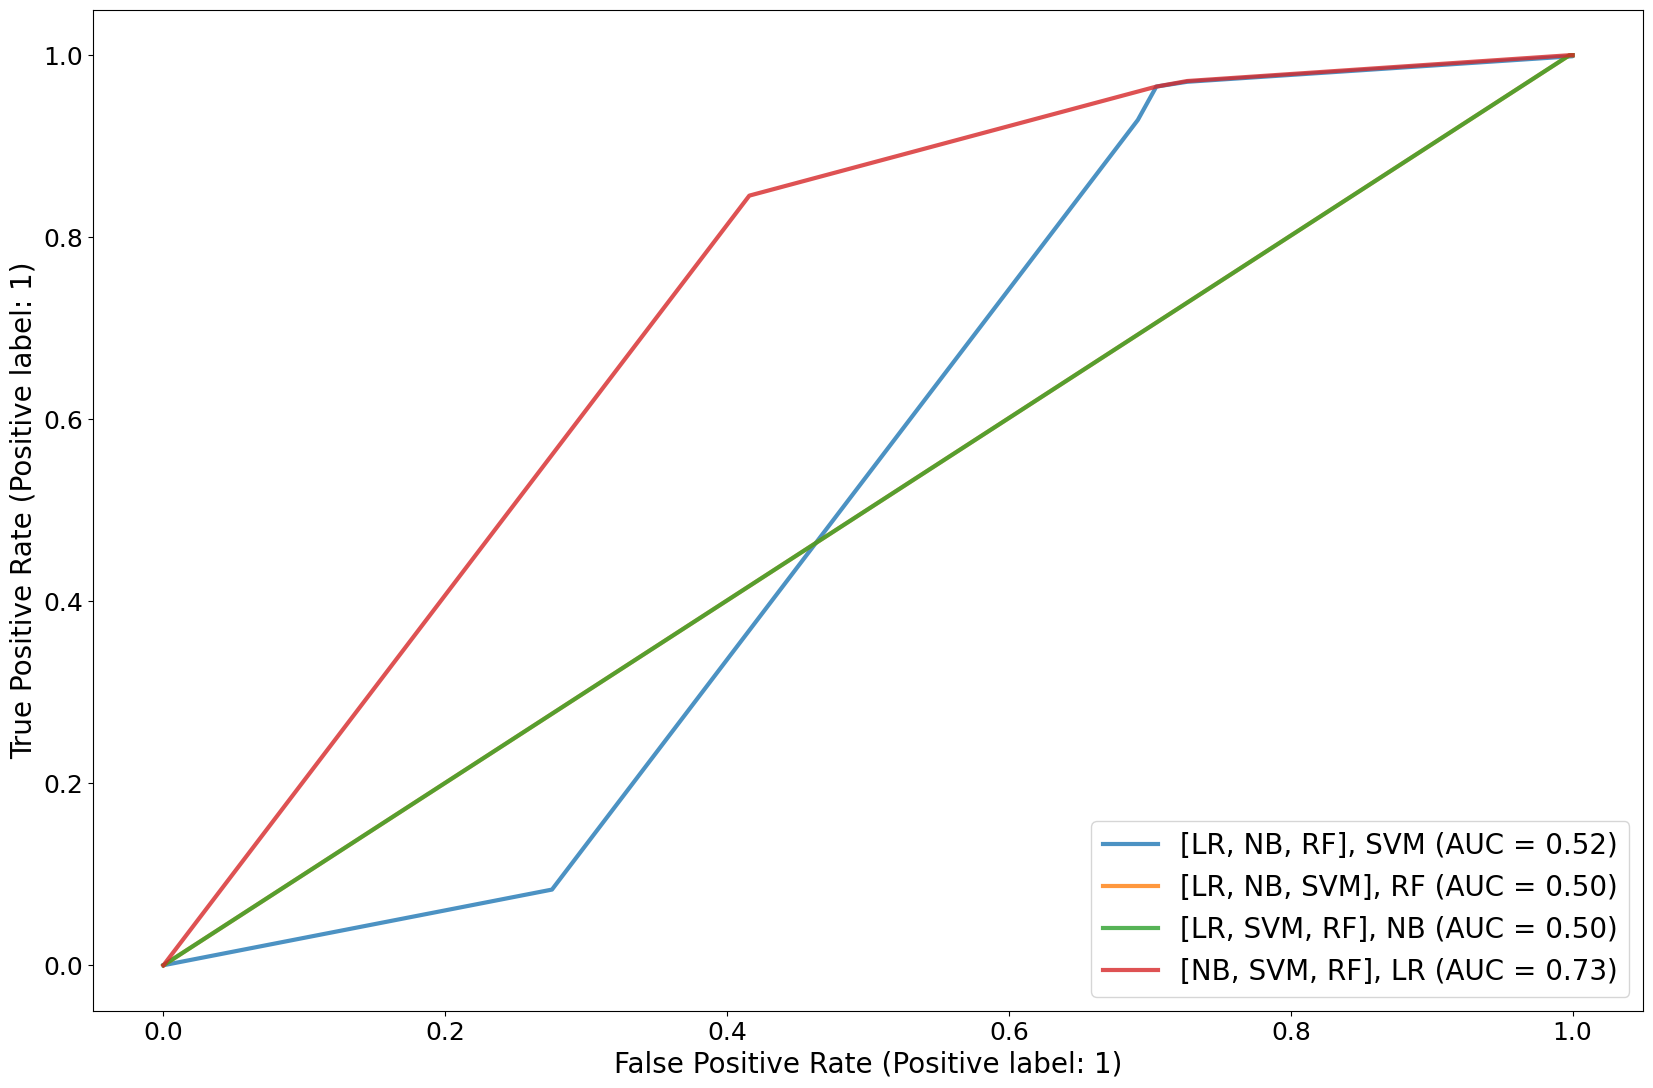

In [24]:
#Stacked classifier 
# SVM_clf = SVC(kernel='rbf', C = 10, gamma = 0.90, random_state = 40)
# RFR_clf = RandomForestClassifier(max_depth = None, n_estimators = 1000, random_state = 40)
# LOG_clf= LogisticRegression(random_state = 40, max_iter = 100, solver = 'newton-cholesky')
# NBY_clf = GaussianNB()


# [LOG_clf, NBY_clf, RFR_clf], SVM_clf Stacked classifier 
STK_clf1 = StackingClassifier(classifiers = [LOG_clf, NB_clf, RFR_clf], 
                              meta_classifier = SVM_clf)
STK_clf1 = STK_clf1.fit(xtrain, ytrain.values.ravel())
ypred1 = STK_clf1.predict_proba(xtest)

plt.rcParams['figure.figsize'] = [20, 13]
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 20

ax = plt.gca()
stk_disp1 = RocCurveDisplay.from_predictions(ytest, ypred1[:,1], ax=ax, alpha=0.8,
                                             name="[LR, NB, RF], SVM")

# [LOG_clf, NBY_clf, SVM_clf], RFR_clf Stacked classifier 
STK_clf2 = StackingClassifier(classifiers = [LOG_clf, NB_clf, SVM_clf], 
                              meta_classifier = RFR_clf)
STK_clf2 = STK_clf2.fit(xtrain, ytrain.values.ravel())
ypred2 = STK_clf2.predict_proba(xtest)

ax = plt.gca()
stk_disp2 = RocCurveDisplay.from_predictions(ytest, ypred2[:,1], ax=ax, alpha=0.8,
                                           name="[LR, NB, SVM], RF")

# [LOG_clf, SVM_clf, RFR_clf], NBY_clf Stacked classifier 
STK_clf3 = StackingClassifier(classifiers = [LOG_clf, SVM_clf, RFR_clf], 
                              meta_classifier = NB_clf)
STK_clf3 = STK_clf3.fit(xtrain, ytrain.values.ravel())
ypred3 = STK_clf3.predict_proba(xtest)

ax = plt.gca()
stk_disp3 = RocCurveDisplay.from_predictions(ytest, ypred3[:,1], ax=ax, alpha=0.8,
                                           name="[LR, SVM, RF], NB")

# [NBY_clf, SVM_clf, RFR_clf], LOG_clf Stacked classifier 
STK_clf4 = StackingClassifier(classifiers = [NB_clf, SVM_clf, RFR_clf], 
                              meta_classifier = LOG_clf)
STK_clf4 = STK_clf4.fit(xtrain, ytrain.values.ravel())
ypred4 = STK_clf4.predict_proba(xtest)

ax = plt.gca()
stk_disp4 = RocCurveDisplay.from_predictions(ytest, ypred4[:,1], ax=ax, alpha=0.8,
                                           name="[NB, SVM, RF], LR")

# [SVM_clf], LOG_clf Stacked classifier 
# STK_clf5 = StackingClassifier(classifiers = [SVM_clf], meta_classifier = LOG_clf)
# STK_clf5 = STK_clf5.fit(xtrain, ytrain.values.ravel())
# ypred5 = STK_clf5.predict_proba(xtest)

# ax = plt.gca()
# stk_disp5 = RocCurveDisplay.from_predictions(ytest, ypred5[:,1], ax=ax, alpha=0.8, name="[SVM], LR")

# Save the stacked models
joblib.dump(STK_clf1, 'STK_clf1.pkl')
joblib.dump(STK_clf2, 'STK_clf2.pkl')
joblib.dump(STK_clf3, 'STK_clf3.pkl')
joblib.dump(STK_clf4, 'STK_clf4.pkl')
# joblib.dump(STK_clf5, 'STK_clf5.pkl')

### Test performance of stack classifiers

In [25]:
# Summarize the fit of the model "[LR, NB, RF], SVM"

# Predict target 
ypred1 = STK_clf1.predict(xtest)

print('Classification reports [LR, NB, RF], SVM')
print('Classification report:\n', metrics.classification_report(ytest, ypred1))
print('F1 Score: ', metrics.f1_score(ytest, ypred1))
print('Accuracy Score: ', metrics.accuracy_score(ytest, ypred1))
print('Confusion matrix:\n', metrics.confusion_matrix(ytest, ypred1))

Classification reports [LR, NB, RF], SVM
Classification report:
               precision    recall  f1-score   support

           0       0.52      0.30      0.38       457
           1       0.92      0.97      0.94      3597

    accuracy                           0.89      4054
   macro avg       0.72      0.63      0.66      4054
weighted avg       0.87      0.89      0.88      4054

F1 Score:  0.9396645021645021
Accuracy Score:  0.889985199802664
Confusion matrix:
 [[ 135  322]
 [ 124 3473]]


In [26]:
# Summarize the fit of the model "[LR, NB, SVM], RF"

# Predict target 
ypred2 = STK_clf2.predict(xtest)
# True and false positive rate  
# fpr, tpr, thresholds = metrics.roc_curve(ytest, ypred2)

print('Classification reports [LR, NB, SVM], RF')
print('Classification report:\n', metrics.classification_report(ytest, ypred2))
print('F1 Score: ', metrics.f1_score(ytest, ypred2))
# print('AUC: ', metrics.auc(fpr, tpr))
print('Accuracy Score: ', metrics.accuracy_score(ytest, ypred2))
print('Confusion matrix:\n', metrics.confusion_matrix(ytest, ypred2))

Classification reports [LR, NB, SVM], RF
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       457
           1       0.89      1.00      0.94      3597

    accuracy                           0.89      4054
   macro avg       0.94      0.50      0.47      4054
weighted avg       0.90      0.89      0.83      4054

F1 Score:  0.9403921568627451
Accuracy Score:  0.88751850024667
Confusion matrix:
 [[   1  456]
 [   0 3597]]


In [27]:
# Summarize the fit of the model "LR, SVM, RF], NB"

# Predict target 
ypred3 = STK_clf3.predict(xtest)
# True and false positive rate  
# fpr, tpr, thresholds = metrics.roc_curve(ytest, ypred3)

print('Classification reports [LR, SVM, RF], NB')
print('Classification report:\n', metrics.classification_report(ytest, ypred3))
print('F1 Score: ', metrics.f1_score(ytest, ypred3))
# print('AUC: ', metrics.auc(fpr, tpr))
print('Accuracy Score: ', metrics.accuracy_score(ytest, ypred3))
print('Confusion matrix:\n', metrics.confusion_matrix(ytest, ypred3))

Classification reports [LR, SVM, RF], NB
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       457
           1       0.89      1.00      0.94      3597

    accuracy                           0.89      4054
   macro avg       0.94      0.50      0.47      4054
weighted avg       0.90      0.89      0.83      4054

F1 Score:  0.9403921568627451
Accuracy Score:  0.88751850024667
Confusion matrix:
 [[   1  456]
 [   0 3597]]


In [28]:
# Summarize the fit of the model "[NB, SVM, RF], LR"

# Predict target 
ypred4 = STK_clf4.predict(xtest)
# True and false positive rate  
# fpr, tpr, thresholds = metrics.roc_curve(ytest, ypred4)

print('Classification reports [NB, SVM, RF], LR')
print('Classification report:\n', metrics.classification_report(ytest, ypred4))
print('F1 Score: ', metrics.f1_score(ytest, ypred4))
# print('AUC: ', metrics.auc(fpr, tpr))
print('Accuracy Score: ', metrics.accuracy_score(ytest, ypred4))
print('Confusion matrix:\n', metrics.confusion_matrix(ytest, ypred4))

Classification reports [NB, SVM, RF], LR
Classification report:
               precision    recall  f1-score   support

           0       0.55      0.27      0.37       457
           1       0.91      0.97      0.94      3597

    accuracy                           0.89      4054
   macro avg       0.73      0.62      0.65      4054
weighted avg       0.87      0.89      0.88      4054

F1 Score:  0.941540948275862
Accuracy Score:  0.8929452392698569
Confusion matrix:
 [[ 125  332]
 [ 102 3495]]


In [29]:
print('Detailed description of LR algorithm')
print(LOG_clf)
print('Detailed description of SVM algorithm')
print(SVM_clf)
print('Detailed description of RF algorithm')
print(RFR_clf)
print('Detailed description of NB algorithm')
print(NB_clf)
print('Detailed description of Stacked classifier 1')
print(STK_clf1)
print('Detailed description of Stacked classifier 2')
print(STK_clf2)
print('Detailed description of Stacked classifier 3')
print(STK_clf3)
print('Detailed description of Stacked classifier 4')
print(STK_clf4)
# print('Detailed description of Stacked classifier 5')
# print(STK_clf5)

Detailed description of LR algorithm
LogisticRegression(random_state=40, solver='newton-cholesky')
Detailed description of SVM algorithm
SVC(C=10, gamma=0.9, probability=True, random_state=40)
Detailed description of RF algorithm
RandomForestClassifier(n_estimators=1000, random_state=40)
Detailed description of NB algorithm
GaussianNB()
Detailed description of Stacked classifier 1
StackingClassifier(classifiers=[LogisticRegression(random_state=40,
                                                   solver='newton-cholesky'),
                                GaussianNB(),
                                RandomForestClassifier(n_estimators=1000,
                                                       random_state=40)],
                   meta_classifier=SVC(C=10, gamma=0.9, probability=True,
                                       random_state=40))
Detailed description of Stacked classifier 2
StackingClassifier(classifiers=[LogisticRegression(random_state=40,
                                

## Comment on model evaluations

The end !